Load the final dataset

In [22]:
import pandas as pd
df = pd.read_csv("../final_dataset_with_likes.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 50 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          1504 non-null   int64  
 1   experiments         1504 non-null   object 
 2   total_experiments   1504 non-null   int64  
 3   total_samples       1504 non-null   int64  
 4   interface           1504 non-null   object 
 5   countries           1504 non-null   object 
 6   languages           1504 non-null   object 
 7   search_queries      1504 non-null   object 
 8   video_id            1504 non-null   int64  
 9   video_title         1504 non-null   object 
 10  video_url           1504 non-null   object 
 11  video_link          1504 non-null   object 
 12  description         1504 non-null   object 
 13  creator_id          1504 non-null   object 
 14  creator_url         1504 non-null   object 
 15  creator_link        1504 non-null   object 
 16  user_a

# Bootstrapping the mean of the sentiment score

Bootstrapping in statistics is a form of hypothesis testing that involves resampling a single data set to create a multitude of simulated samples. This samples might be used to compute standard errors, confidence intervals...

I will use it to compute the mean of the sentiment score in order to relate it with other features of interest

Bootstrapped 95% CI for 'sentiment_score': [0.178, 0.253]


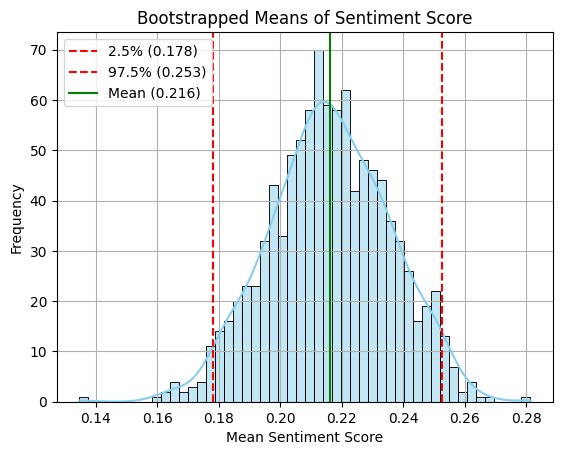

In [23]:
import pandas as pd
import numpy as np

# Defining the hyperparameters
n_iterations = 1000
sample_size = len(df)
boot_means = []

# Bootstrapping loop
for i in range(n_iterations):
    sample = df.sample(n=sample_size, replace=True)
    mean = sample['sentiment_score'].mean()
    boot_means.append(mean)

# Calculating confidence interval
ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

# The mean of the whole population is between this two points
print(f"Bootstrapped 95% CI for 'sentiment_score': [{ci_lower:.3f}, {ci_upper:.3f}]")

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(boot_means, bins=50, kde=True, color='skyblue')
plt.axvline(ci_lower, color='red', linestyle='--', label=f'2.5% ({ci_lower:.3f})')
plt.axvline(ci_upper, color='red', linestyle='--', label=f'97.5% ({ci_upper:.3f})')
plt.axvline(np.mean(boot_means), color='green', linestyle='-', label=f'Mean ({np.mean(boot_means):.3f})')
plt.title("Bootstrapped Means of Sentiment Score")
plt.xlabel("Mean Sentiment Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


Conclusion: Since the sentiment score range is [-1,1], we can extract from here that most of the videos are slightly "positive" (at least when referring the vocabulary used) more than "negative"

Mean sentiment score depending on the topic

/tmp/ipykernel_1877/3217758019.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=boot_df, x='topic', y='boot_mean', palette='Set2', inner='quartile')


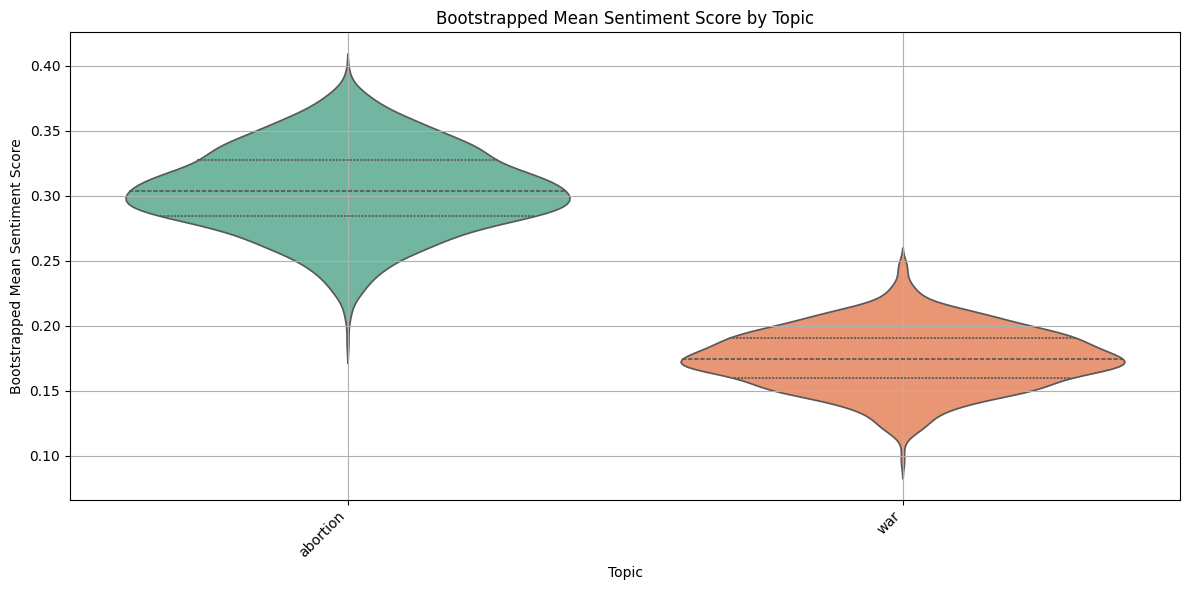

In [24]:
# Parameters
n_iterations = 1000
boot_results = []

# Group by topic and run bootstrapping
for topic, group in df.groupby('topic'):
    scores = group['sentiment_score'].dropna()
    
    for _ in range(n_iterations):
        # "replace=True" means that each row can be selected more than once per group
        sample = scores.sample(n=len(scores), replace=True)
        boot_results.append({
            'topic': topic,
            'boot_mean': sample.mean()
        })

# Convert to DataFrame
boot_df = pd.DataFrame(boot_results)

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(data=boot_df, x='topic', y='boot_mean', palette='Set2', inner='quartile')
plt.title("Bootstrapped Mean Sentiment Score by Topic")
plt.xlabel("Topic")
plt.ylabel("Bootstrapped Mean Sentiment Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(True)
plt.show()


Conclusion: As expected, both topics have a majority of positive vocabulary, this suggests that the language used in both topics, despite the challenging or sensitive nature, includes positive terms that may frame the topics in a way that encourages positive sentiments. 

Abortion related content has a grater score on most of the videos, since it is a associated to positive feelings such as "independence" or "freedom". These emotions are often connected with empowerment or rights which encourages positive sentiments. The negative sentiments for the war topic are reflected in the lower sentiment, as they are tied to the harsher and more distressing realities of war (deaths, destructions, sadness).

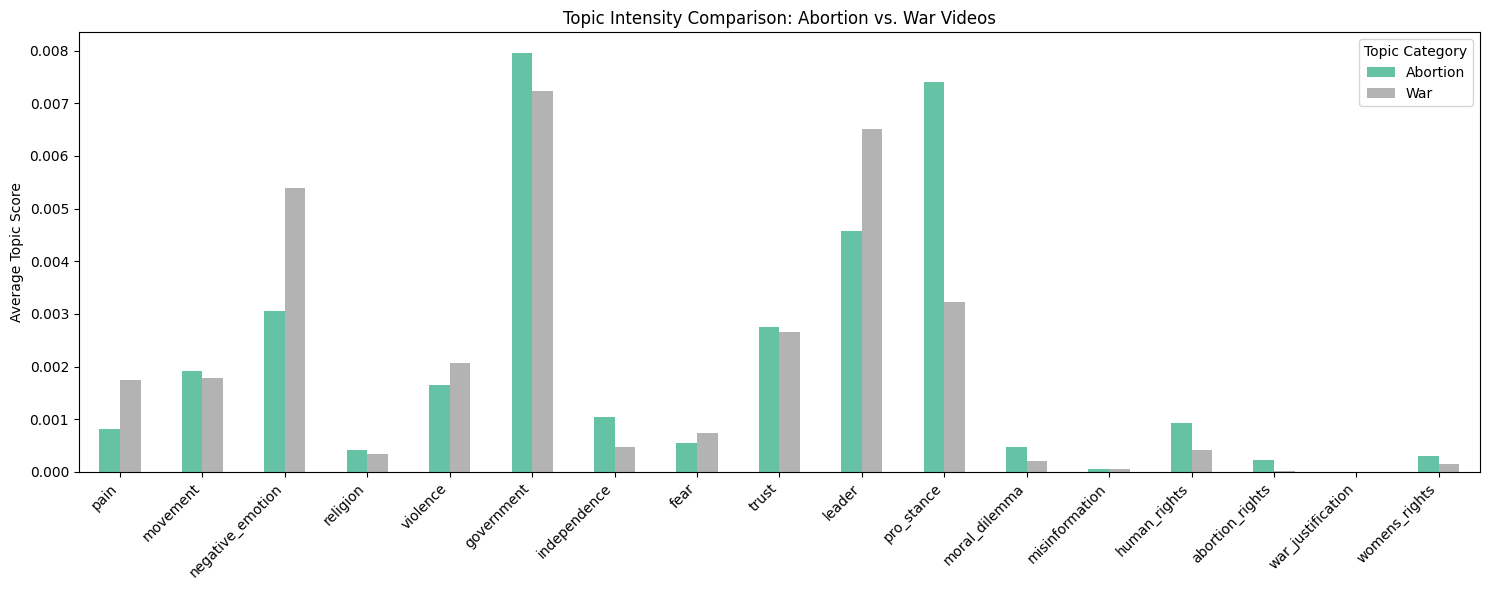

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# List of relevant topics
topics = [
    'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights'
]

# Filter for abortion and war videos
abortion_df = df[df['topic'].str.lower().str.contains('abortion')]
war_df = df[df['topic'].str.lower().str.contains('war')]

# Calculate average scores for each topic in both subsets
abortion_means = abortion_df[topics].mean()
war_means = war_df[topics].mean()

# Combine into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Abortion': abortion_means,
    'War': war_means
})

# Plot side-by-side bars
comparison_df.plot(kind='bar', figsize=(15, 6), colormap='Set2')
plt.title("Topic Intensity Comparison: Abortion vs. War Videos")
plt.ylabel("Average Topic Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Topic Category')
plt.tight_layout()
plt.show()


As we can see on this table, on war-related content we find more sentiments that can be related with negative ideas such as pain, violence, fear or (as expected) negative emotion. The only other sentiment where there is a noticeable difference is when the idea of is mentioned "leader".

To determine wether this ideas impact the sentiment score by themselves we can check their relation directly:

In [26]:
# List of topics of interest
topics = [
    'subjectivity', 'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights'
]

# Function to perform bootstrapping and return the mean sentiment score
def bootstrap_mean(data, n_iterations=1000):
    means = []
    for _ in range(n_iterations):
        sample = data.sample(n=len(data), replace=True)
        means.append(sample['sentiment_score'].mean())
    return np.mean(means)

# Dictionary to hold the bootstrap mean sentiment scores for each topic
bootstrap_topic_scores = {}

# Compute the bootstrap mean sentiment score for each topic
for topic in topics:
    subset = df[df[topic] > 0]  # Filter rows where the topic score is greater than 0
    if not subset.empty:
        mean_boot = bootstrap_mean(subset)
        bootstrap_topic_scores[topic] = mean_boot

# Sort the bootstrap scores in descending order
bootstrap_topic_scores_sorted = dict(sorted(bootstrap_topic_scores.items(), key=lambda x: x[1], reverse=True))

# Output the results
print("Bootstrap Mean Sentiment Scores for each Topic:")
for topic, score in bootstrap_topic_scores_sorted.items():
    print(f"{topic}: {score:.3f}")


Bootstrap Mean Sentiment Scores for each Topic:
trust: 0.533
pro_stance: 0.469
violence: 0.397
religion: 0.296
pain: 0.290
subjectivity: 0.238
movement: 0.211
government: 0.197
independence: 0.195
fear: 0.189
moral_dilemma: 0.097
negative_emotion: 0.092
leader: 0.075
womens_rights: 0.064
human_rights: -0.013
abortion_rights: -0.420
misinformation: -0.588


/tmp/ipykernel_1877/2190662713.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=scores_df, x='Bootstrap Mean Sentiment Score', y='Topic', palette='viridis')


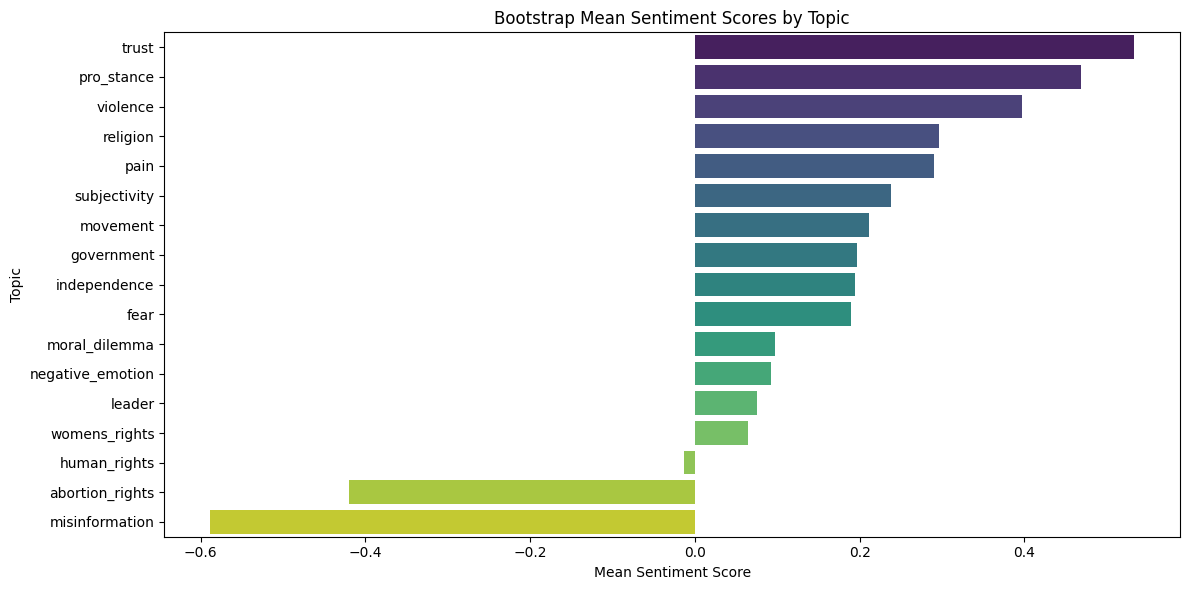

In [27]:
# Plot
scores_df = pd.DataFrame(list(bootstrap_topic_scores_sorted.items()), columns=['Topic', 'Bootstrap Mean Sentiment Score'])

plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, x='Bootstrap Mean Sentiment Score', y='Topic', palette='viridis')
plt.title('Bootstrap Mean Sentiment Scores by Topic')
plt.xlabel('Mean Sentiment Score')
plt.ylabel('Topic')
plt.tight_layout()
plt.show()

As contrary as I was expecting, the sentiments that were related to war content is not intrinsically negative, on the contrary, most of the ideas we have seen on the analysis performed before are associated to positive sentiment scores.

This means that the negative tone must come from another source, we can try investigation the geographical influence and the political ideology to find answers.

Finally, we can work with the correlation between topics:

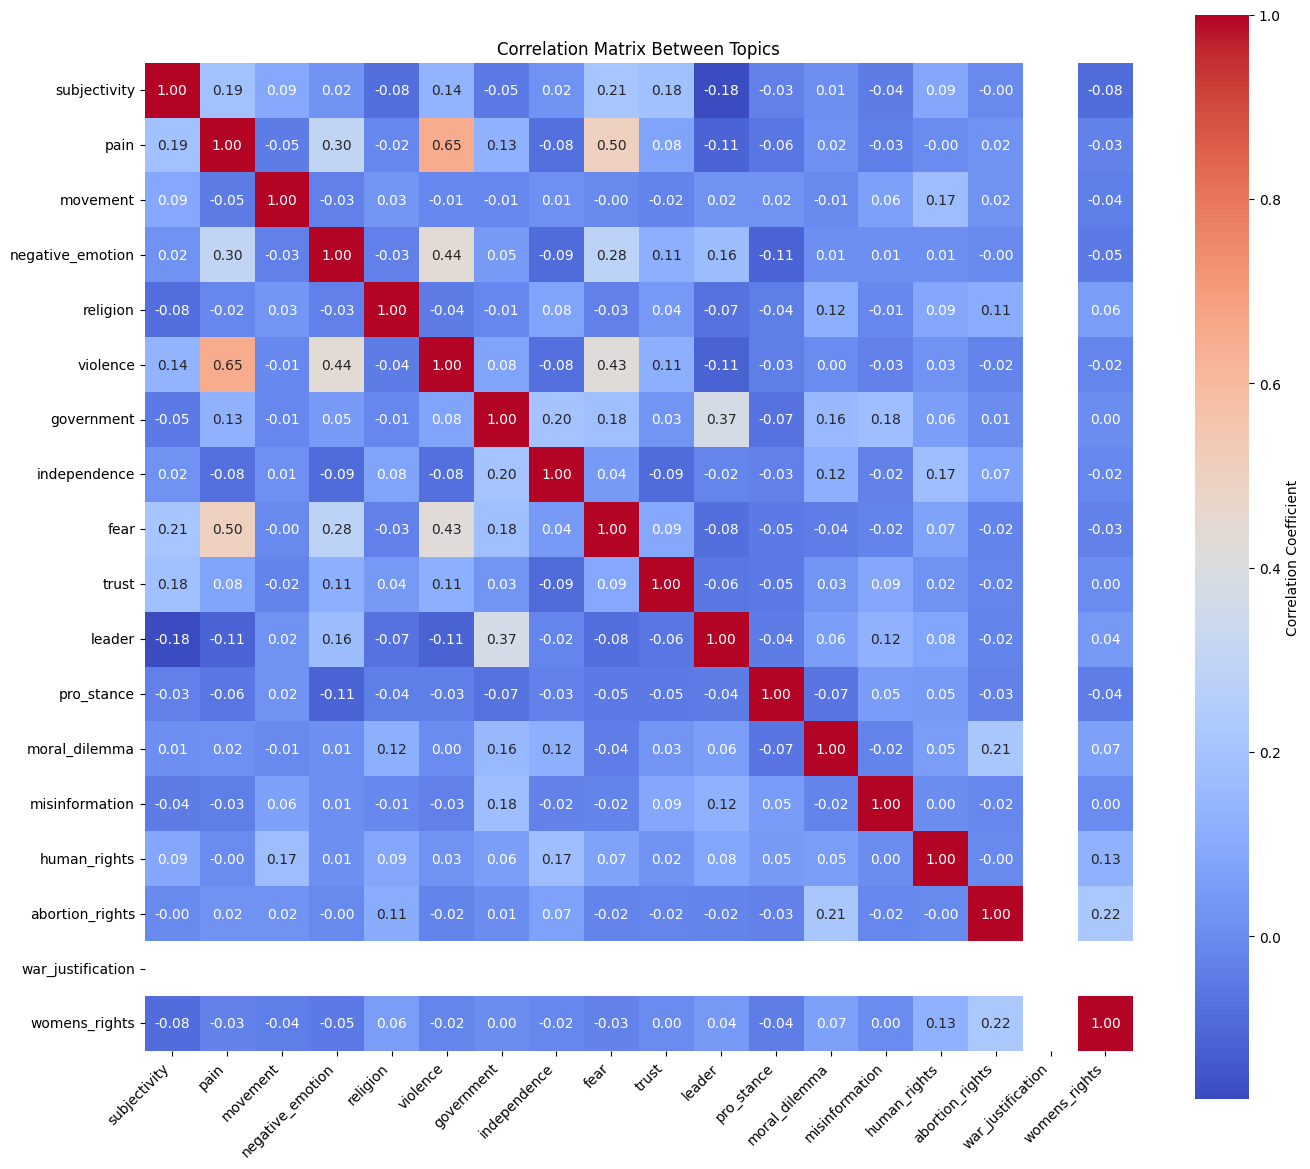

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of topics
topics = [
    'subjectivity', 'pain', 'movement', 'negative_emotion', 'religion',
    'violence', 'government', 'independence', 'fear', 'trust', 'leader',
    'pro_stance', 'moral_dilemma', 'misinformation', 'human_rights',
    'abortion_rights', 'war_justification', 'womens_rights'
]

# Extract topic data from the DataFrame (make sure df is already defined)
topic_data = df[topics].dropna()

# Compute the correlation matrix
corr_matrix = topic_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True,
            cbar_kws={"label": "Correlation Coefficient"})
plt.title("Correlation Matrix Between Topics")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Mean sentiment score depending on the country

Sentiment score by country

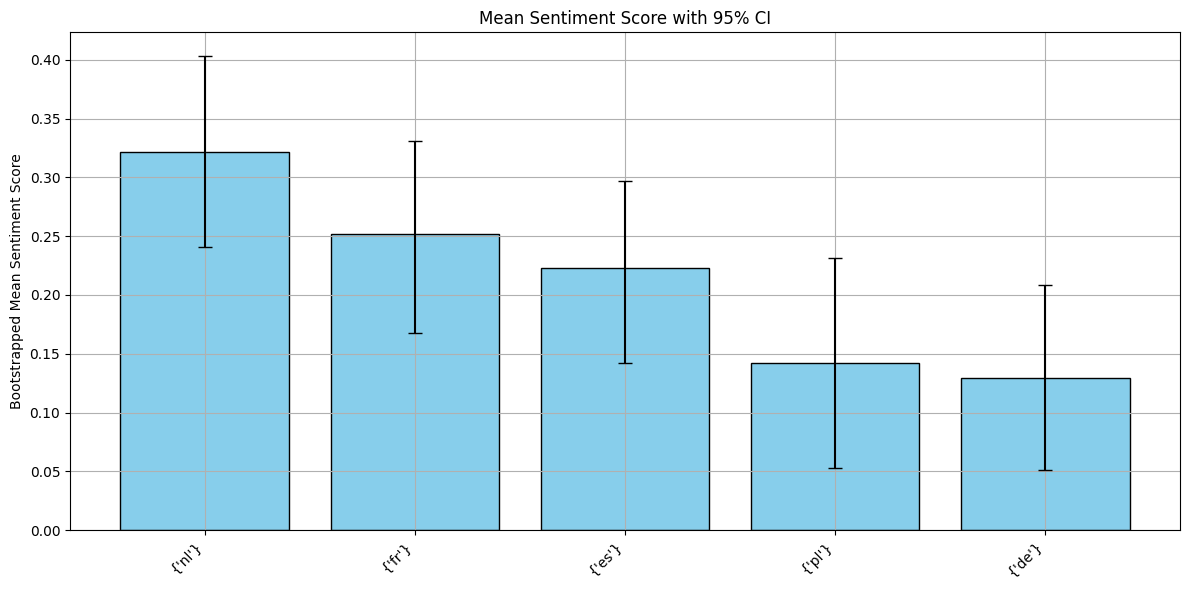

In [28]:
# Parameters
n_iterations = 1000
boot_data = []

# Group by 'countries'
for country, group in df.groupby('countries'):
    scores = group['sentiment_score'].dropna()
    
    means = []
    for _ in range(n_iterations):
        sample = scores.sample(n=len(scores), replace=True)
        means.append(sample.mean())
    
    ci_lower = np.percentile(means, 2.5)
    ci_upper = np.percentile(means, 97.5)
    boot_data.append({
        'country': country,
        'mean': np.mean(means),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    })

# Convert to DataFrame
boot_df = pd.DataFrame(boot_data)
boot_df.sort_values(by='mean', ascending=False, inplace=True)

# Plot
plot = boot_df.head(15)
plt.figure(figsize=(12, 6))
plt.bar(plot['country'], plot['mean'], yerr=[plot['mean'] - plot['ci_lower'], plot['ci_upper'] - plot['mean']],
        capsize=5, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Bootstrapped Mean Sentiment Score')
plt.title('Mean Sentiment Score with 95% CI')
plt.tight_layout()
plt.grid(True)
plt.show()


All five countries exhibit a general trend of maintaining a positive mean sentiment score. However, Poland and Germany report the lowest sentiment scores among them. These discrepancies can be attributed to the distinct sociopolitical contexts each country faces.

While both Poland and Germany have long since legalized abortion, their geographical proximity to the ongoing Russia-Ukraine conflict may contribute to a heightened awareness of the surrounding geopolitical tensions. This proximity could lead to a more somber or negative tone in discussions surrounding sensitive topics such as abortion and war, in contrast to the other countries in the analysis.

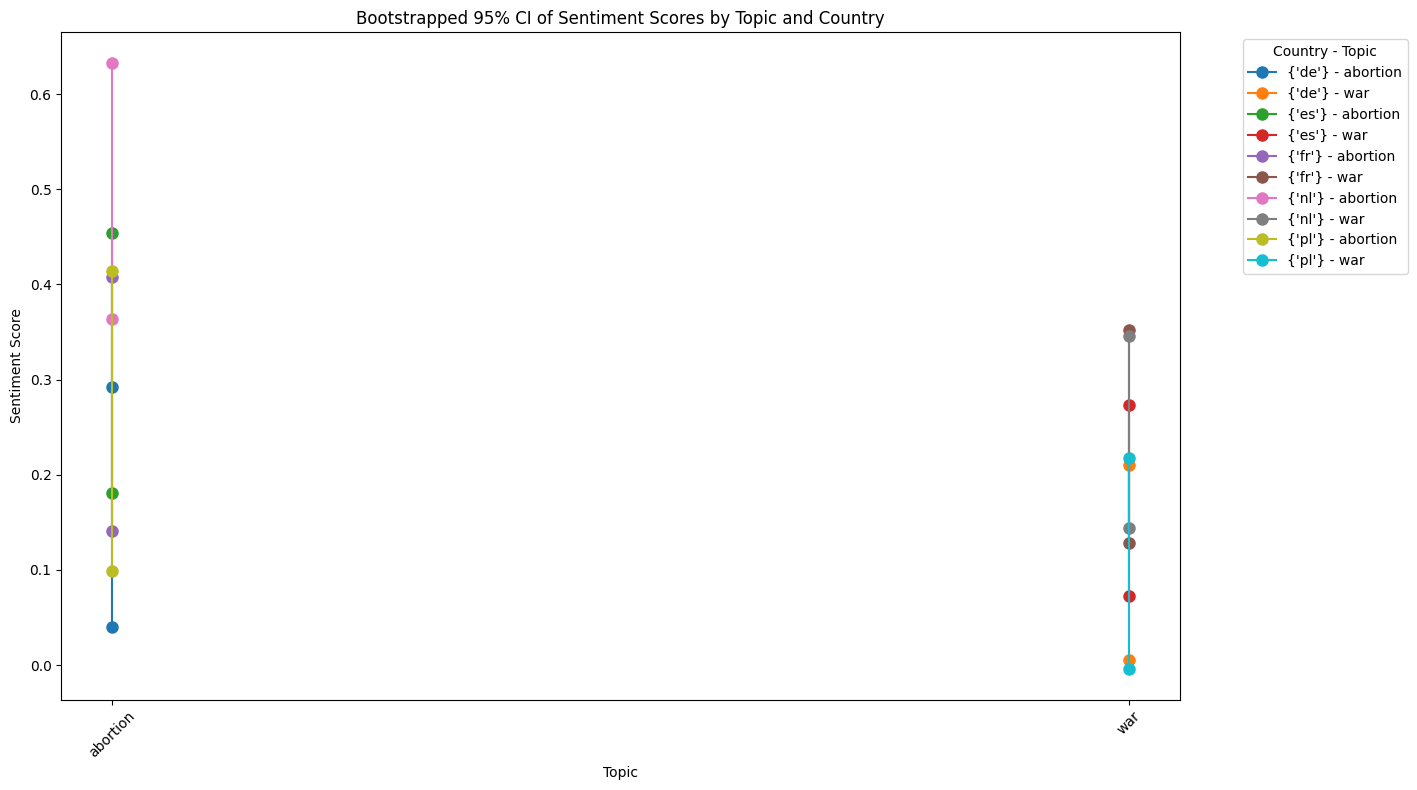

In [29]:
# Define the number of bootstrap iterations
n_iterations = 1000

# Function to compute bootstrapped confidence intervals
def bootstrap_ci(data, n_iterations=1000, percentile_range=(2.5, 97.5)):
    boot_means = []
    for _ in range(n_iterations):
        sample = data.sample(n=len(data), replace=True)
        boot_means.append(sample.mean())
    ci_lower = np.percentile(boot_means, percentile_range[0])
    ci_upper = np.percentile(boot_means, percentile_range[1])
    return ci_lower, ci_upper

# Create a combined plot for all countries
plt.figure(figsize=(12, 8))

# Loop through each country in the dataframe
for country, group in df.groupby('countries'):
    # Iterate through each topic within the country
    for topic, topic_data in group.groupby('topic'):
        # Get bootstrapped confidence intervals for the sentiment score of each topic
        ci_lower, ci_upper = bootstrap_ci(topic_data['sentiment_score'])
        
        # Plot the confidence intervals, using country as a label for each line
        plt.plot([topic, topic], [ci_lower, ci_upper], marker='o', markersize=8, label=f'{country} - {topic}')

# Add title and labels
plt.title('Bootstrapped 95% CI of Sentiment Scores by Topic and Country')
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.tight_layout()

# Add a legend to differentiate countries
plt.legend(title='Country - Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.show()


As expected both Poland and Germany have the lower sentiment scores when talking about both topics. While we could argue that this is due to geological reasons (in the case of war-content) we still need to find a reason behind the abortion negativeness.

Low sentiment score when referring to abortion could be explained by the presence of right-associated ideology which is usually relation to anti-abortion discourse:

In [30]:
# Group by country and calculate mean for '% left' and '% right'
mean_ideology = df.groupby('countries')[['% left', '% right']].mean().reset_index()

# Display the result
print(mean_ideology)

  countries    % left   % right
0    {'de'}  0.515698  0.236595
1    {'es'}  0.620640  0.264809
2    {'fr'}  0.565903  0.319593
3    {'nl'}  0.527495  0.218014
4    {'pl'}  0.471189  0.323385


While most of the countries have a majority of left %, Poland holds the biggest amount of right-political parties mentioned. 

So lets see if mentioning right political parties is related to having a lower sentiment score:

Correlation between sentiment score and % right (abortion videos): -0.278


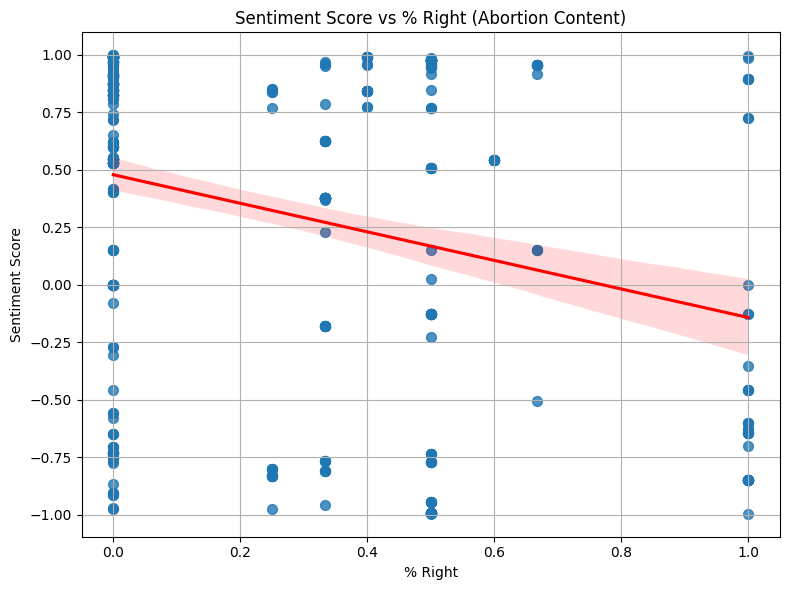

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter for abortion-related content
abortion_df = df[df['topic'].str.lower() == 'abortion']

# 2. Drop rows with missing values in sentiment or % right
abortion_clean = abortion_df[['sentiment_score', '% right']].dropna()

# 3. Correlation
correlation = abortion_clean['sentiment_score'].corr(abortion_clean['% right'])
print(f"Correlation between sentiment score and % right (abortion videos): {correlation:.3f}")

# 4. Visualize
plt.figure(figsize=(8, 6))
sns.regplot(data=abortion_clean, x='% right', y='sentiment_score', scatter_kws={'s': 50}, line_kws={'color': 'red'})
plt.title('Sentiment Score vs % Right (Abortion Content)')
plt.xlabel('% Right')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()



As observed, there is a negative correlation between the percentage of right-leaning language and sentiment score in abortion-related content. This suggests that a higher presence of right-leaning ideological framing is associated with more negative sentiment when discussing abortion.

This pattern could help explain Poland’s notably low sentiment scores, as it is the country with the highest percentage of right-leaning discourse in the dataset. In contrast, this explanation does not fully apply to Germany, which also shows lower sentiment scores but does not exhibit a particularly elevated % Right value. Therefore, in Germany’s case, the negative sentiment may stem from other sociopolitical factors or thematic nuances in the content rather than ideological framing alone.

That is why it will be interesting to study how the other factors of the dataset might affect the sentiment score.

Finally, it is also interesting to generally analysis whether the % of right and left parties mentioned influences the sentiment score to see if this is an isolated case for abortion or if it holds for both topics:

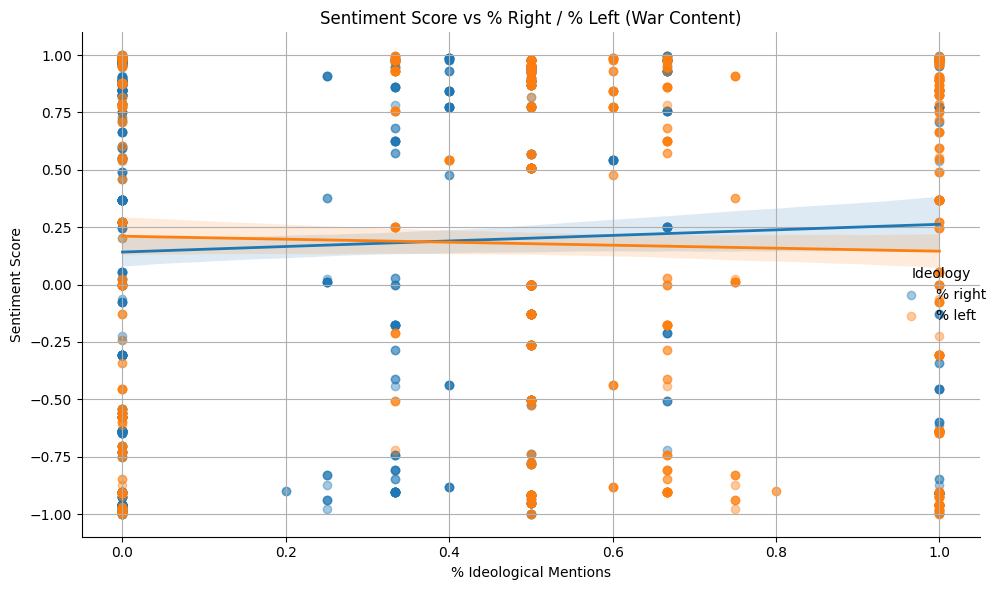

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Filter for war-related content
war_df = df[df['topic'].str.lower() == 'war']

# 2. Drop missing values
war_clean = war_df[['sentiment_score', '% right', '% left']].dropna()

# 3. Reshape the data
war_melted = war_clean.melt(id_vars='sentiment_score',
                            value_vars=['% right', '% left'],
                            var_name='Ideology',
                            value_name='Percentage')

# 4. Plot using lmplot
sns.lmplot(
    data=war_melted,
    x='Percentage',
    y='sentiment_score',
    hue='Ideology',
    height=6,
    aspect=1.5,
    scatter_kws={'alpha': 0.4},
    line_kws={'linewidth': 2}
)

plt.title('Sentiment Score vs % Right / % Left (War Content)')
plt.xlabel('% Ideological Mentions')
plt.ylabel('Sentiment Score')
plt.grid(True)
plt.tight_layout()
plt.show()


In this case, the most the % of right political parties mentioned the lower the sentiment score is, so we can't not generalize the statement done before.

# Relating sentiment score with engagement

sentiment_score    1.000000
average_order      0.145583
likes             -0.085623
followers         -0.086761
Name: sentiment_score, dtype: float64


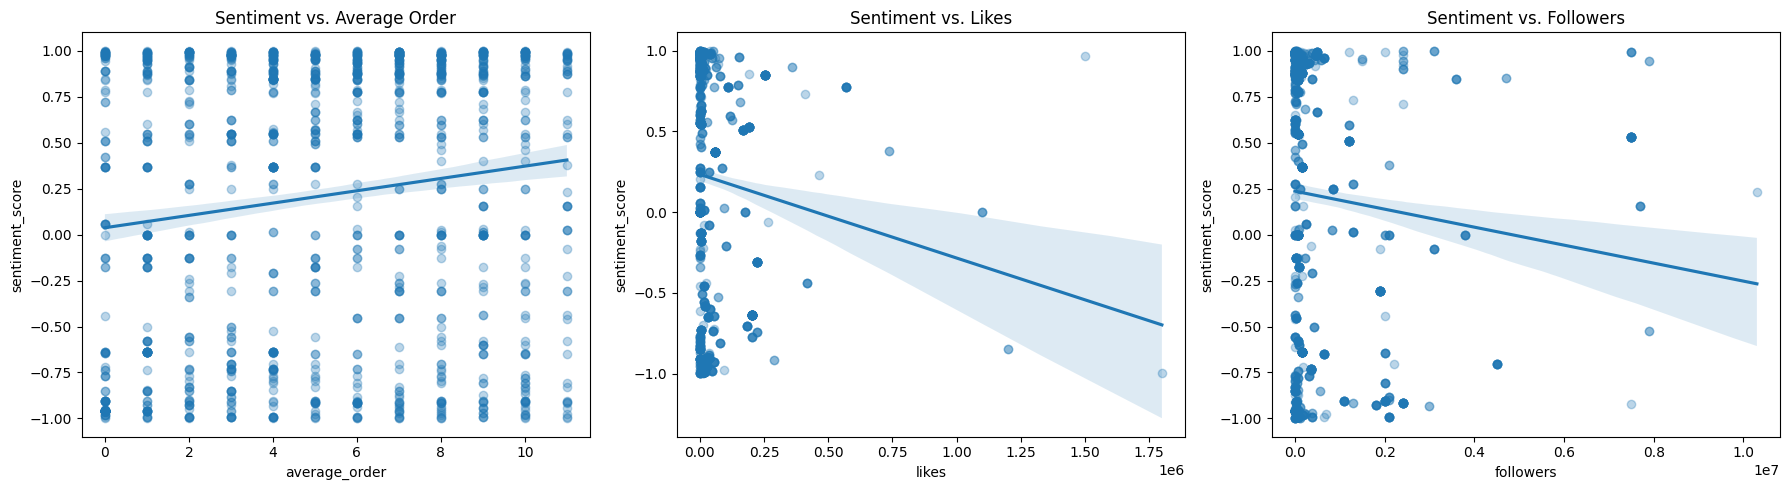

In [32]:
# Subset the relevant columns
cols = ['sentiment_score', 'average_order', 'likes', 'followers']
subset = df[cols].dropna()

# Pearson correlation
correlation_matrix = subset.corr()

print(correlation_matrix['sentiment_score'])

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.regplot(data=subset, x='average_order', y='sentiment_score', ax=axes[0], scatter_kws={'alpha':0.3})
axes[0].set_title('Sentiment vs. Average Order')

sns.regplot(data=subset, x='likes', y='sentiment_score', ax=axes[1], scatter_kws={'alpha':0.3})
axes[1].set_title('Sentiment vs. Likes')

sns.regplot(data=subset, x='followers', y='sentiment_score', ax=axes[2], scatter_kws={'alpha':0.3})
axes[2].set_title('Sentiment vs. Followers')

plt.tight_layout()
plt.show()

The Pearson correlation analysis reveals a very weak negative relationship between sentiment score and both likes (r = -0.09) and followers (r = -0.09). These low coefficients suggest that sentiment is not significantly associated with user engagement, at least in terms of popularity metrics such as likes or follower count.

Although the regression plots display a slight downward trend (indicating that higher engagement may coincide with more negative sentiment) this effect appears to be largely driven by a small number of high-engagement outliers. As such, the visual pattern lacks statistical support and should be interpreted with caution.

In contrast, the correlation with average order is slightly stronger but still weak (r = 0.15). Interestingly, this weak positive correlation also hints at a possible tendency for videos with lower sentiment scores to rank more prominently, echoing the pattern seen in the plots.

While further analysis falls beyond the scope of this work, it would be worth exploring whether content with more negative sentiment tends to perform better or gain more visibility, potentially due to emotional engagement or platform-specific dynamics.